# Projected density of states (PDOS)
For the source code, see [pdos](https://workgraph-collections.readthedocs.io/en/latest/qe/module.html#workgraph_collections.ase.espresso.pdos.pdos_workgraph).

## Example: Silicon

### Prepare the inputs 

In [1]:
from copy import deepcopy
from aiida import load_profile
from aiida.orm import Dict, KpointsData, StructureData, load_code, load_group
from ase.build import bulk

from workgraph_collections.qe.pdos import PdosWorkGraph

load_profile()

atoms = bulk('Si')
structure_si = StructureData(ase=atoms)

pw_code = load_code('pw-7.4@localhost')
dos_code = load_code('dos-7.4@localhost')
projwfc_code = load_code('projwfc-7.4@localhost')
paras = {
    'CONTROL': {
        'calculation': 'scf',
    },
    'SYSTEM': {
        'ecutwfc': 30,
        'ecutrho': 240,
        'occupations': 'smearing',
        'smearing': 'gaussian',
        'degauss': 0.1,
    },
}
nscf_paras = deepcopy(paras)
nscf_paras['CONTROL']['calculation'] = 'nscf'
nscf_paras['SYSTEM']['occupations'] = 'tetrahedra'

kpoints = KpointsData()
kpoints.set_kpoints_mesh([3, 3, 3])
nscf_kpoints = KpointsData()
nscf_kpoints.set_kpoints_mesh([10, 10, 10])
#
metadata = {
    'options': {
        'resources': {
            'num_machines': 1,
            'num_mpiprocs_per_machine': 1,
        },
    }
}

pdos_inputs = {
    'scf': {
        'pw': {
            'parameters': Dict(paras),
            'metadata': metadata,
        },
        'kpoints': kpoints,
    },
    'nscf': {
        'pw': {
            'parameters': Dict(nscf_paras),
            'metadata': metadata,
        },
        'kpoints': kpoints,
    },
    'dos': {
        'metadata': metadata,
    },
    'projwfc': {
        'metadata': metadata,
    },
}

wg = PdosWorkGraph.build_graph(structure=structure_si,
                    pw_code=pw_code,
                    dos_code=dos_code,
                    projwfc_code=projwfc_code,
                    inputs=pdos_inputs,
                    pseudo_family='SSSP/1.3/PBEsol/efficiency',
                    run_scf=True,
                    )
wg.to_html()

### Run the WorkGraph

In [2]:
wg.run()

09/02/2025 01:37:54 PM <1340270> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [175279|WorkGraphEngine|continue_workgraph]: tasks ready to run: PwBaseWorkChain
09/02/2025 01:37:56 PM <1340270> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [175279|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 175282
09/02/2025 01:38:05 PM <1340270> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [175282|PwBaseWorkChain|run_process]: launching PwCalculation<175285> iteration #1
09/02/2025 01:38:13 PM <1340270> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [175282|PwBaseWorkChain|results]: work chain completed after 1 iterations
09/02/2025 01:38:13 PM <1340270> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [175282|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
09/02/2025 01:38:14 PM <1340270> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [

Print the results

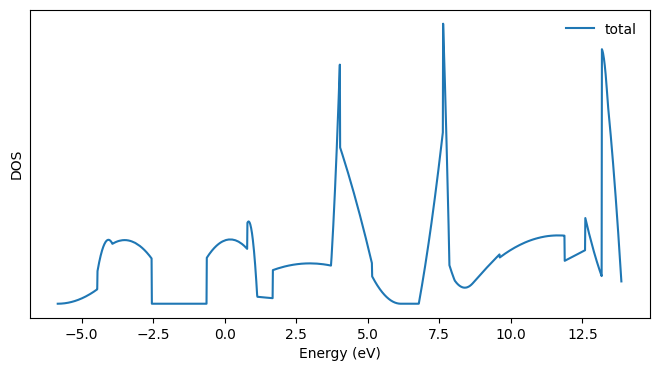

In [3]:
import matplotlib.pyplot as plt
import numpy as np
#------------------------- Print the output -------------------------
dos_data = wg.outputs.dos.output_dos.value
# pdos_data = wg.tasks['projwfc'].outputs["results"].value.value
# make plots
plt.figure(figsize = (8, 4))
plt.plot(dos_data.get_array("x_array"), dos_data.get_array("y_array_1"), label='total')
# plt.plot(pdos_data['totol']['energy'], pdos_data['totol']['dos'], label='total')
# for file_name, data in pdos_data['atom'].items():
        # value = np.array(data)
        # plt.plot(value[:, 0], np.sum(value[:, 2:], axis=1), label=file_name[-4:])
plt.yticks([])
plt.xlabel('Energy (eV)')
plt.ylabel('DOS')
plt.legend(frameon=False)